In [ ]:
import torch
from torch import nn
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

import os

In [ ]:
train_dir = "/content/drive/MyDrive/ml/flower_classification/flower_dataset/train"
test_dir = "/content/drive/MyDrive/ml/flower_classification/flower_dataset/test"

In [ ]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
transform = weights.transforms()

simple_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=transform,
                                  target_transform=None,
                                  )

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=transform,
                                 target_transform=None)

In [ ]:
len(train_data)

13642

In [ ]:
class_names = train_data.classes

In [ ]:
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=os.cpu_count() )
test_dataloader = DataLoader(test_data, batch_size=32,shuffle=False, num_workers=os.cpu_count())

In [ ]:
model = torchvision.models.efficientnet_b0(weights=weights).to(device)


In [ ]:
try:
  import torchinfo
except:
  !pip install torchinfo

In [ ]:
from torchinfo import summary
summary(model, input_size=(32, 3, 224, 224),
         col_names=["input_size","output_size","num_params","trainable"],
         col_width=20,
         row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [ ]:
 ### freezing the base model and changing the output model to suit our needs

for param in model.features.parameters():
  param.requires_grad = False

In [ ]:
from torch import nn

torch.manual_seed(42)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280,
              out_features=len(class_names))
)

model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=14, bias=True)
)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc



In [ ]:
summary(model, input_size=(32, 3, 224, 224),
         col_names=["input_size","output_size","num_params","trainable"],
         col_width=20,
         row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 14]             --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [ ]:
image , label = next(iter(train_dataloader))
image, label = image.to(device), label.to(device)


y_logits = model(image[0].unsqueeze(dim=0))
y_pred_prob = torch.softmax(y_logits, dim=1)




In [ ]:
y_logits, y_logits.argmax(dim=1), y_pred_prob.argmax(dim=1), label[0]

(tensor([[-0.0241, -0.1535,  0.0591,  0.1126, -0.0256,  0.0827, -0.0840, -0.0352,
          -0.0594, -0.0897, -0.0306, -0.0873, -0.0068, -0.0447]],
        device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor([3], device='cuda:0'),
 tensor([3], device='cuda:0'),
 tensor(6, device='cuda:0'))

In [ ]:
def train_step(model,dataloader, loss_fn, optimizer, accuracy_fn):
  model.train()
  train_loss, train_acc = 0, 0
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy_fn(y, y_pred.argmax(dim=1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if(batch % 100 == 0):
      print(f"Looked at {batch * len(X)}/{len(dataloader.dataset)} samples \n")

  train_loss /= len(dataloader)
  train_acc /= len(dataloader)
  return train_loss, train_acc

In [ ]:
def test_step(model, dataloader, loss_fn, optimizer, accuracy_fn):
  model.eval()
  test_loss, test_acc = 0, 0
  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)

      test_pred = model(X)
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y, test_pred.argmax(dim=1))

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)
    return test_loss, test_acc

In [ ]:
def train(model, train_dataloader, test_dataloader, optimizer, loss_fn, epochs, accuracy_fn):
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []
             }

  for epoch in range(epochs):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       accuracy_fn=accuracy_fn)
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)

    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    optimizer=optimizer,
                                    accuracy_fn=accuracy_fn)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

    print(f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}")

  return results

In [ ]:
epoches = 10
results = train(model, train_dataloader, test_dataloader, optimizer, loss_fn, epoches, accuracy_fn)

Looked at 0/13642 samples 

Looked at 3200/13642 samples 

Looked at 6400/13642 samples 

Looked at 9600/13642 samples 

Looked at 12800/13642 samples 

Epoch: 1 | train_loss: 0.8068 | train_acc: 80.4947 | test_loss: 0.5628 | test_acc: 78.9062
Looked at 0/13642 samples 

Looked at 3200/13642 samples 

Looked at 6400/13642 samples 

Looked at 9600/13642 samples 

Looked at 12800/13642 samples 

Epoch: 2 | train_loss: 0.4166 | train_acc: 88.1060 | test_loss: 0.5822 | test_acc: 80.4688
Looked at 0/13642 samples 

Looked at 3200/13642 samples 

Looked at 6400/13642 samples 

Looked at 9600/13642 samples 

Looked at 12800/13642 samples 

Epoch: 3 | train_loss: 0.3593 | train_acc: 89.2067 | test_loss: 0.5453 | test_acc: 81.2500
Looked at 0/13642 samples 

Looked at 3200/13642 samples 

Looked at 6400/13642 samples 

Looked at 9600/13642 samples 

Looked at 12800/13642 samples 

Epoch: 4 | train_loss: 0.3266 | train_acc: 90.2313 | test_loss: 0.5023 | test_acc: 81.2500
Looked at 0/13642 sample

In [ ]:
torch.save(model,"/content/drive/MyDrive/ml/flower_classification/model.pt")

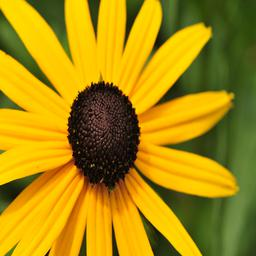

In [ ]:
img = Image.open("/content/drive/MyDrive/ml/flower_classification/flower_dataset/test/black_eyed_susan/3746555853_4c778bc568_c.jpg")

img

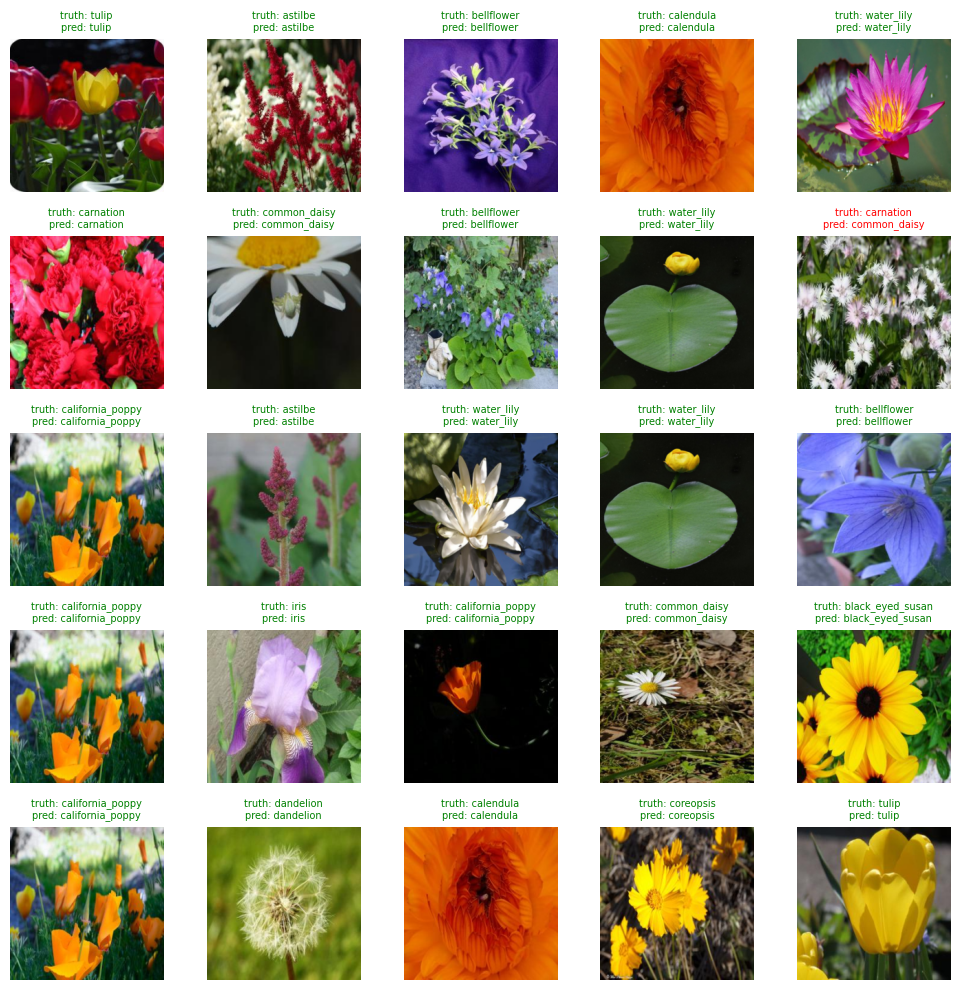

In [ ]:
import os
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import random



def pred_and_plot(model, data_dir):
  model.eval()
  with torch.inference_mode():
    plt.figure(figsize=(10, 10))

    for i in range(25):
      # Randomly select a class folder and an image
      class_folder = random.choice(os.listdir(data_dir))
      if(class_folder not in class_names):
        class_folder = random.choice(os.listdir(data_dir))

      image_name = random.choice(os.listdir(os.path.join(data_dir,class_folder)))

      class_path = os.path.join(data_dir, class_folder)
      image_name = random.choice(os.listdir(class_path))
      image_path = os.path.join(class_path, image_name)


      # Load the image
      img = Image.open(image_path)
      label = class_names.index(class_folder)

      # Transform the image
      transformed_image = transform(img)
      simple_transformed_image = simple_transform(img)

      # Perform prediction
      y_logits = model(transformed_image.unsqueeze(dim=0).to(device))
      y_pred = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)
      y_label = class_names[y_pred]
      y_true = class_names[label]

      # Plot the image
      plt.subplot(5, 5, i + 1)
      color = "green" if y_label == y_true else "red"
      plt.imshow(simple_transformed_image.permute(1, 2, 0))
      plt.title(f"truth: {y_true}\npred: {y_label}", color=color, fontsize=7)
      plt.axis("off")

    plt.tight_layout()
    plt.show()

# Call the function with the model and directory path
data_dir = "/content/drive/MyDrive/ml/flower_classification/flower_dataset/test"
pred_and_plot(model, data_dir)


In [ ]:
def eval_model(model,test_dataloader,loss_fn,accuracy_fn):
  model.eval()
  with torch.inference_mode():
    y_preds=[]
    loss = 0
    accuracy = 0
    for X, y in test_dataloader:
      X, y = X.to(device), y.to(device)

      test_logits = model(X)
      y_preds.append(test_logits.argmax(dim=1))

      loss += loss_fn(test_logits, y)
      accuracy += accuracy_fn(test_logits.argmax(dim=1), y)

    y_preds = torch.cat(y_preds)
    return {
        "loss": loss/len(test_dataloader),
        "accuracy": accuracy/len(test_dataloader),
        "preds": y_preds
    }


result = eval_model(model,test_dataloader,loss_fn,accuracy_fn)
print(f"loss: {result['loss']}")
print(f"accuracy: {result['accuracy']:.3f}%")

loss: 0.5615018606185913
accuracy: 82.031%


In [ ]:
y_preds = result["preds"]
y_true = torch.tensor([label for _, label in test_data])

In [ ]:
try:
  import torchmetrics

except:
  !pip install torchmetrics

from torchmetrics.classification import MulticlassConfusionMatrix

matrix = MulticlassConfusionMatrix(num_classes=len(class_names)).to(device)
matx  = matrix(y_preds.to(device), y_true.to(device))


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

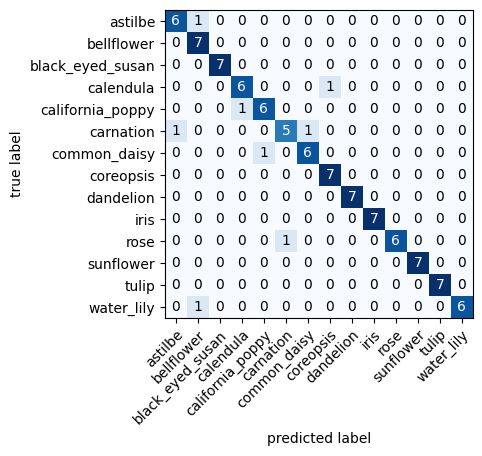

In [ ]:
from mlxtend.plotting import plot_confusion_matrix

plot_confusion_matrix(conf_mat = matx.to("cpu").numpy(),figsize=(4,4), class_names=class_names);